In [2]:
# Check this paper: https://proceedings.neurips.cc/paper_files/paper/2019/file/c9efe5f26cd17ba6216bbe2a7d26d490-Paper.pdf
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

sns.set_style('white')

results_path = Path('data', 'time_gan')
if not results_path.exists():
    results_path.mkdir()
experiment = 0

log_dir = results_path / f'experiment_{experiment:02}'

if not log_dir.exists():
    log_dir.mkdir(parents=True)
hdf_store = results_path / 'TimeSeriesGAN.h5'

Using GPU


In [4]:
# Prepare Data
seq_len = 24 # parameter setting by the paper of TimeGAN
n_seq = 6
batch_size = 128
tickers = ['DIS', 'MSFT', 'AAPL', 'GE', 'JPM', 'ORCL']

In [5]:
# def select_data():
#     df = (pd.read_hdf('data/assets.h5', 'quandl/wiki/prices').adj_close.unstack('ticker').loc['2000':, tickers]
#           .dropna())
#     df.to_hdf(hdf_store, 'data/real')
#
# select_data()

In [6]:
import FinanceDataReader as fdr

temp_df = pd.concat([fdr.DataReader(ticker, start='2005-01-01')['Adj Close'] for ticker in tickers], axis=1)
temp_df.columns=tickers
temp_df.to_hdf(hdf_store, 'data/real')

In [7]:
temp_df.sample(10).sort_index()

,DIS,MSFT,AAPL,GE,JPM,ORCL
Date,,,,,,
2007-10-26,28.855686,25.511784,5.606586,159.438324,31.481245,17.622561
2008-06-25,27.563955,20.872150,5.384693,113.726448,25.649811,18.613054
2009-05-01,18.892521,15.165369,3.862382,54.823204,22.713978,16.004971
2013-09-18,61.009220,27.961735,14.503485,122.988327,40.400681,29.103636
2018-04-17,99.360825,90.470657,42.421314,79.788780,94.224083,42.956558
2021-04-07,187.559998,244.937256,126.204185,82.986000,145.201599,71.717323
2021-05-24,174.309998,246.367386,125.627808,81.684494,153.270996,76.858665
2021-11-22,154.160004,335.101563,159.626022,78.396286,155.851257,92.262665
2022-06-10,99.400002,250.567947,136.316025,55.364983,114.892822,65.974518


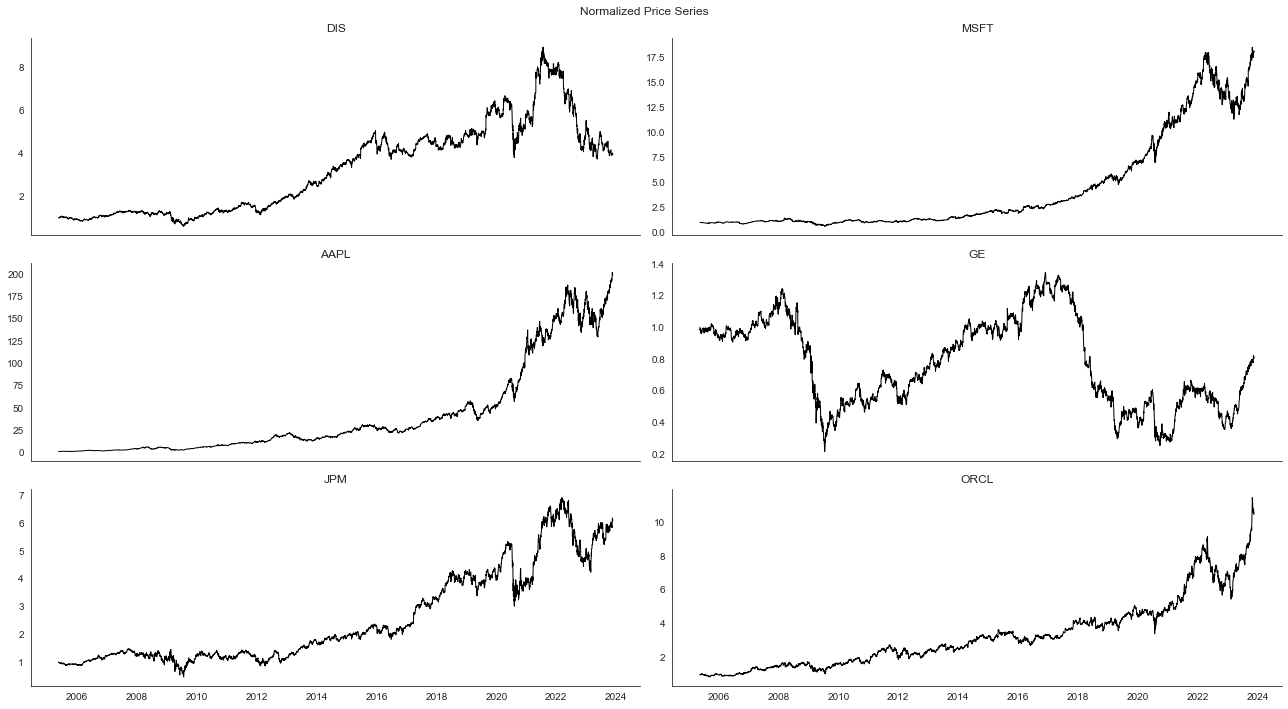

In [8]:
# Plot Series
df = pd.read_hdf(hdf_store, 'data/real')
axes = df.div(df.iloc[0]).plot(subplots=True, figsize=(18, 10), layout=(3, 2), title=tickers, legend=False,
                               rot=0, lw=1, color='k')

for ax in axes.flatten():
    ax.set_xlabel('')

plt.suptitle('Normalized Price Series')
plt.gcf().tight_layout()
sns.despine();

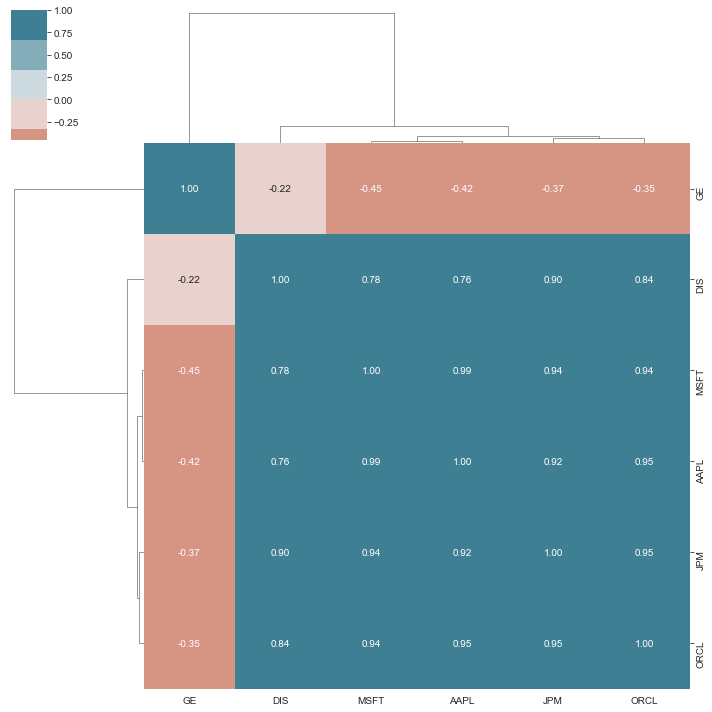

In [9]:
# Correlation
sns.clustermap(df.corr(), annot=True, fmt='.2f', cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);

In [10]:
# Normalize Data for synthetic data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32)

# Create rolling window sequences containing overlapping of 24 consecutive data points for the above 6 series
data = []
for i in range(len(df) - seq_len):
    data.append(scaled_data[i:i + seq_len])

n_windows = len(data)
n_windows

4634

In [11]:
data[:5]

[array([[4.8743945e-02, 2.2037556e-02, 0.0000000e+00, 6.9385624e-01,
         8.2110554e-02, 1.3328925e-02],
        [4.7451653e-02, 2.2246026e-02, 5.1111496e-05, 6.8322545e-01,
         8.0510892e-02, 1.0860599e-02],
        [4.6805494e-02, 2.2120947e-02, 9.5150797e-05, 6.7790985e-01,
         8.0830798e-02, 1.1142679e-02],
        [4.6977799e-02, 2.2058405e-02, 9.9083249e-05, 6.8491662e-01,
         8.1710674e-02, 1.1988996e-02],
        [4.5814779e-02, 2.1891635e-02, 4.6867144e-04, 6.7960125e-01,
         8.0470935e-02, 1.2764714e-02],
        [4.6288576e-02, 2.2162640e-02, 4.4586943e-04, 6.7742634e-01,
         7.9950988e-02, 1.1777403e-02],
        [4.5987073e-02, 2.2016713e-02, 9.9865596e-05, 6.6510385e-01,
         7.8471422e-02, 1.1847925e-02],
        [4.8183944e-02, 2.2120947e-02, 1.7064453e-04, 6.7186940e-01,
         7.8831367e-02, 1.3822571e-02],
        [4.8313186e-02, 2.1057721e-02, 5.1192322e-04, 6.6099638e-01,
         7.7951416e-02, 1.3822571e-02],
        [5.0682366e

In [13]:
# Create tf.data.Dataset instance and set the shuffle during training
real_series = (tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=n_windows).batch(batch_size))
real_series_iter = iter(real_series.repeat())

# Set up random series generator for simulation
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

random_series = iter(tf.data.Dataset.from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size).repeat())
random_series

In [14]:
# TimeGAN Components
hidden_dim = 24
num_layers = 3

writer = tf.summary.create_file_writer(log_dir.as_posix()) # Set up logger

# Input placeholders
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

In [15]:
# RNN block generator
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units, return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units, activation='sigmoid', name='OUT')], name=name)

In [16]:
# Embedder & Recovery
embedder = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=hidden_dim, name='Embedder')
recovery = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=n_seq, name='Recovery')

# Generator & Discriminator
generator = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=hidden_dim, name='Generator')
discriminator = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=1, name='Discriminator')
supervisor = make_rnn(n_layers=2, hidden_units=hidden_dim, output_units=hidden_dim, name='Supervisor')

In [17]:
# TimeGAN Training

# Settings
train_steps = 10000
gamma = 1

# Generic Loss Functions
mse = MeanSquaredError()
bce = BinaryCrossentropy()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10104     
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 21,054
Trainable params: 21,054
Non-trainable params: 0
_________________________________________________________________


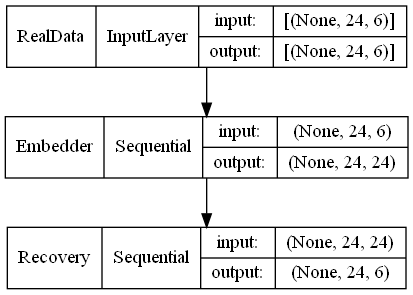

In [18]:
# Phase 1: Autoencoder Training
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X, outputs=X_tilde, name='Autoencoder')
autoencoder.summary()
plot_model(autoencoder, to_file=(results_path / 'autoencoder.png').as_posix(), show_shapes=True)

In [19]:
autoencoder_optimizer = Adam() # Autoencoder Optimizer

# Autoencoder Training Step
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list) # recovery network weights
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

# Autoencoder Training Loop
# Reconstruction loss compares the autoencoder outputs with its inputs
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [11:50<00:00, 14.08it/s]


In [20]:
autoencoder_optimizer.weights

[<tf.Variable 'Adam/iter:0' shape=() dtype=int64, numpy=10000>,
 <tf.Variable 'Adam/GRU_1/gru_cell/kernel/m:0' shape=(6, 72) dtype=float32, numpy=
 array([[ 4.40196200e-05, -1.09298362e-05,  2.35211405e-06,
         -1.47615967e-04, -5.35051622e-05, -1.45221675e-05,
          5.89331830e-06, -5.41582813e-05, -6.81913443e-05,
          1.59769888e-06,  1.80494339e-06,  9.35146236e-05,
         -3.44954133e-05, -5.66038871e-05,  2.68435087e-05,
         -4.58222985e-06, -5.40217570e-06, -2.64245464e-05,
         -6.06363585e-07, -5.76771436e-06, -3.59961705e-05,
          1.69428927e-06, -1.50853555e-06, -4.49247909e-06,
         -9.16751276e-04,  7.46312944e-05, -4.24244819e-04,
         -1.93477143e-04, -8.78380844e-04,  9.00818486e-06,
         -4.42801160e-04, -1.59956922e-04, -2.06711993e-04,
         -9.61953046e-05,  5.54151011e-05, -3.97791940e-04,
          1.14784125e-04, -1.60852633e-03,  3.60368722e-05,
          1.08996886e-04, -4.98864538e-05, -1.33445646e-04,
          1.8

In [21]:
# autoencoder.save(log_dir / 'autoencoder') # Persist model

In [22]:
# Phase 2: Supervised training
supervisor_optimizer = Adam()

# Train Step
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

# Training Loop
# loss compares the output of the supervisor with the next timestep for the embedded sequence to learn the temporal dynamics of the historical price sequences
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [09:49<00:00, 16.97it/s]


In [23]:
# supervisor.save(log_dir / 'supervisor') # Persist Model

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 28,729
Trainable params: 28,729
Non-trainable params: 0
_________________________________________________________________


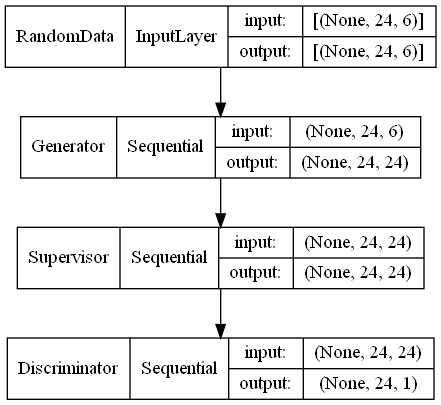

In [24]:
# Phase 3: Joint Training involves all four network components, as well as the supervisor
# to achieve the simultaneous learning of latent space embeddings, transition dynamics, and synthetic data generation

# Adversarial Architecture - Supervised
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z, outputs=Y_fake, name='AdversarialNetSupervised')
adversarial_supervised.summary()
plot_model(adversarial_supervised, show_shapes=True)

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


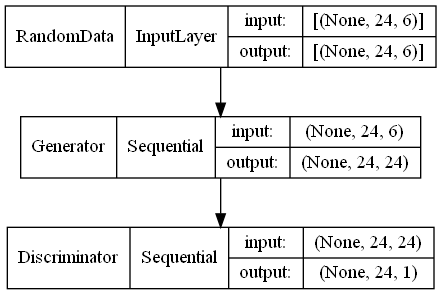

In [25]:
# Adversarial Architecture in Latent Space
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z, outputs=Y_fake_e, name='AdversarialNet')
adversarial_emb.summary()
plot_model(adversarial_emb, show_shapes=True)

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 6)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            10104     
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 6)             10950     
                                                                 
Total params: 28,854
Trainable params: 28,854
Non-trainable params: 0
_________________________________________________________________


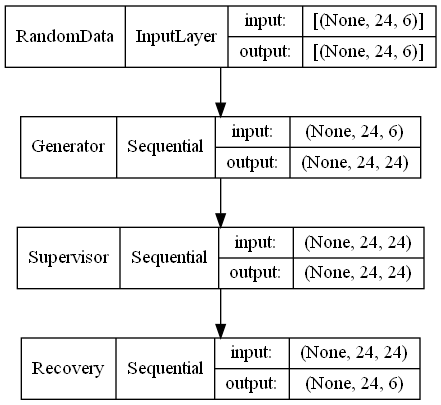

In [26]:
# Mean & Variance Loss
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z, outputs=X_hat, name='SyntheticData')
synthetic_data.summary()
plot_model(synthetic_data, show_shapes=True)

In [27]:
# TimeGAN includes a moment loss to penalize if the mean and variance of the synthetic data deviate from the real one
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 6)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            10104     
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20,929
Trainable params: 20,929
Non-trainable params: 0
_________________________________________________________________


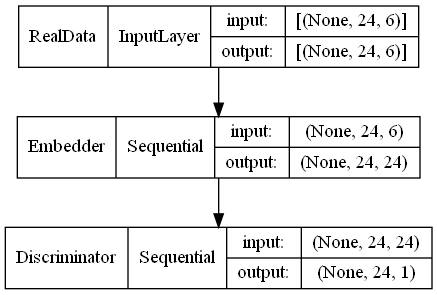

In [28]:
# Discriminator
Y_real = discriminator(H)
discriminator_model = Model(inputs=X, outputs=Y_real, name='DiscriminatorReal')
discriminator_model.summary()
plot_model(discriminator_model, show_shapes=True)

In [29]:
Y_real

<KerasTensor: shape=(None, 24, 1) dtype=float32 (created by layer 'Discriminator')>

In [36]:
# Optimizers
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

# Generator Train Step
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake), y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e), y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised + generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) + 100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))

    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

In [37]:
# Embedding Train Step
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))

    return tf.sqrt(embedding_loss_t0)

In [38]:
# Discriminator Train Step
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real), y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake), y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e), y_pred=y_fake_e)

    return (discriminator_loss_real + discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))

    return discriminator_loss

In [39]:
# Training Loop
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'step:{step:6,.0f} | d_loss:{step_d_loss:6.4f} | g_loss_u:{step_g_loss_u:6.4f} | '
              f'g_loss_s:{step_g_loss_s:6.4f} | g_loss_v:{step_g_loss_v:6.4f} | e_loss_t0:{step_e_loss_t0:6.4f}\n')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

step:     0 | d_loss:1.4675 | g_loss_u:1.4413 | g_loss_s:0.0001 | g_loss_v:0.1149 | e_loss_t0:0.0357

step: 1,000 | d_loss:1.6034 | g_loss_u:1.2238 | g_loss_s:0.0001 | g_loss_v:0.0270 | e_loss_t0:0.0098

step: 2,000 | d_loss:1.1230 | g_loss_u:2.0805 | g_loss_s:0.0002 | g_loss_v:0.0667 | e_loss_t0:0.0092

step: 3,000 | d_loss:1.3723 | g_loss_u:1.4452 | g_loss_s:0.0001 | g_loss_v:0.0424 | e_loss_t0:0.0089

step: 4,000 | d_loss:1.6092 | g_loss_u:1.5806 | g_loss_s:0.0001 | g_loss_v:0.0631 | e_loss_t0:0.0085

step: 5,000 | d_loss:1.3964 | g_loss_u:1.4787 | g_loss_s:0.0001 | g_loss_v:0.0434 | e_loss_t0:0.0082

step: 6,000 | d_loss:1.2211 | g_loss_u:1.5013 | g_loss_s:0.0002 | g_loss_v:0.0802 | e_loss_t0:0.0079

step: 7,000 | d_loss:1.3730 | g_loss_u:1.6517 | g_loss_s:0.0001 | g_loss_v:0.0345 | e_loss_t0:0.0073

step: 8,000 | d_loss:1.4456 | g_loss_u:1.3507 | g_loss_s:0.0001 | g_loss_v:0.0414 | e_loss_t0:0.0077

step: 9,000 | d_loss:1.5394 | g_loss_u:1.6390 | g_loss_s:0.0001 | g_loss_v:0.0259 

In [40]:
# synthetic_data.save(log_dir / 'synthetic_data') # Persist Synthetic Data Generator

In [41]:
# Generate Synthetic Data to evaluate the TimeGAN results
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

len(generated_data)

36

In [42]:
generated_data[:3]

[<tf.Tensor: shape=(128, 24, 6), dtype=float32, numpy=
 array([[[0.7621335 , 0.4292223 , 0.35252336, 0.24686113, 0.65802956,
          0.3435697 ],
         [0.6079562 , 0.443743  , 0.33326855, 0.18704732, 0.63318294,
          0.37264368],
         [0.6098018 , 0.43503618, 0.36090317, 0.14977837, 0.5672625 ,
          0.33281156],
         ...,
         [0.568104  , 0.50288224, 0.38540247, 0.17021644, 0.5716557 ,
          0.35660893],
         [0.5691745 , 0.5044344 , 0.38666138, 0.17014247, 0.5715252 ,
          0.35720786],
         [0.5702208 , 0.5057979 , 0.3877705 , 0.17006336, 0.57143086,
          0.3576896 ]],
 
        [[0.03268835, 0.01721215, 0.01018106, 0.21322222, 0.09057093,
          0.03502452],
         [0.03787812, 0.01517918, 0.01283283, 0.2753273 , 0.1479085 ,
          0.05808902],
         [0.04645137, 0.01645188, 0.01683135, 0.2741466 , 0.1386132 ,
          0.06701282],
         ...,
         [0.03116354, 0.01223667, 0.01014462, 0.2827655 , 0.09980273,
       

In [43]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape # ganarated_data(36) * samples(128) = 4608 & stack dimensions by 24*6

(4608, 24, 6)

In [44]:
np.save(log_dir / 'generated_data.npy', generated_data)

In [45]:
# Rescale
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
generated_data.shape

(4608, 24, 6)

In [50]:
generated_data[:2]

array([[[157.07562  , 155.8915   ,  69.000916 ,  66.11288  ,
         110.985596 ,  49.720577 ],
        [128.01544  , 160.78131  ,  65.28455  ,  57.06539  ,
         107.21385  ,  53.123432 ],
        [128.36331  , 157.84932  ,  70.6183   ,  51.428062 ,
          97.207054 ,  48.461433 ],
        [120.93242  , 159.9041   ,  64.22775  ,  52.21238  ,
          99.55566  ,  47.999947 ],
        [121.15577  , 160.79437  ,  66.1294   ,  53.036278 ,
         100.34545  ,  47.4459   ],
        [120.03109  , 163.6754   ,  67.927605 ,  53.73407  ,
         100.11708  ,  48.14897  ],
        [118.96434  , 165.18835  ,  68.601944 ,  54.147507 ,
          99.77431  ,  48.379574 ],
        [118.732155 , 166.97572  ,  69.54035  ,  54.408634 ,
          99.46587  ,  48.67159  ],
        [118.59297  , 168.5953   ,  70.27106  ,  54.567604 ,
          99.17116  ,  48.976685 ],
        [118.56712  , 170.01929  ,  70.88537  ,  54.647453 ,
          98.914734 ,  49.25282  ],
        [118.62576  , 171.3326

In [47]:
with pd.HDFStore(hdf_store) as store:
    store.put('data/synthetic', pd.DataFrame(generated_data.reshape(-1, n_seq), columns=tickers))

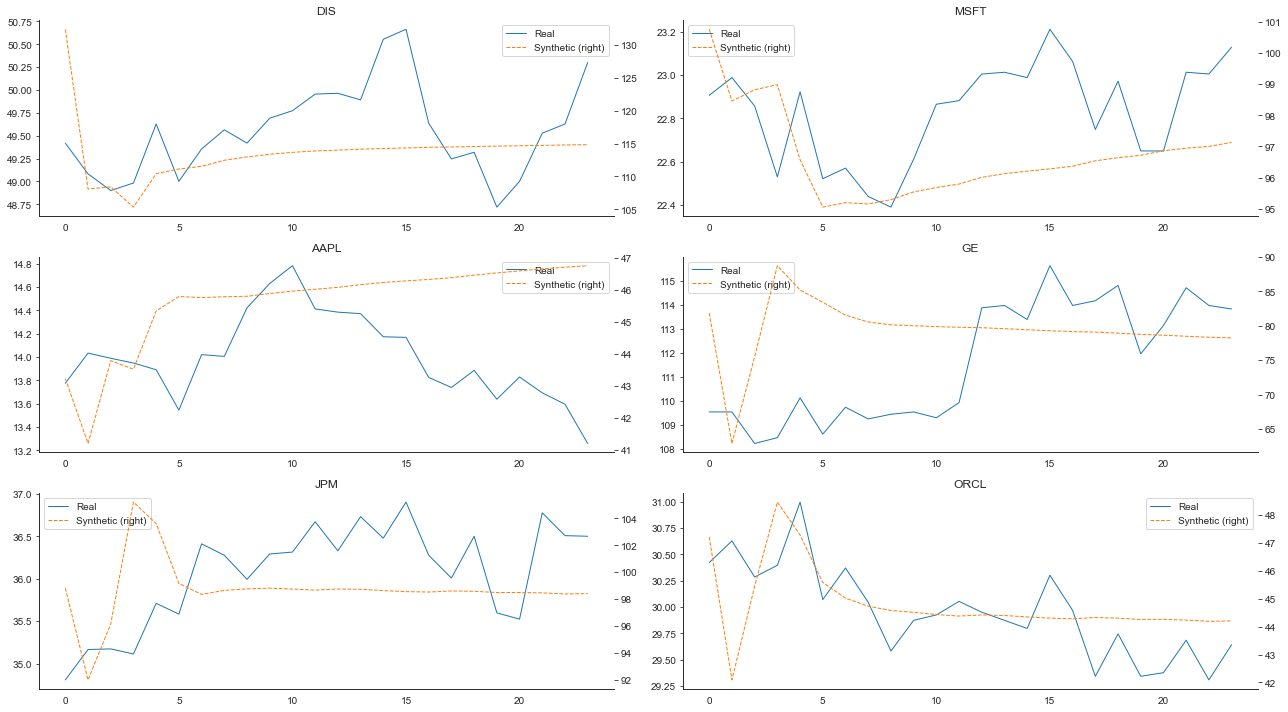

In [60]:
# Plot sample Series
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))
axes = axes.flatten()

index = list(range(1, 25))
synthetic = generated_data[np.random.randint(n_windows)]

idx = np.random.randint(len(df) - seq_len)
real = df.iloc[idx: idx + seq_len]

for j, ticker in enumerate(tickers):
    (pd.DataFrame({'Real': real.iloc[:, j].values, 'Synthetic': synthetic[:, j]}).plot(ax=axes[j],
           title=ticker, secondary_y='Synthetic', style=['-', '--'], lw=1))
sns.despine()
fig.tight_layout()